To begin with let us define, visualize, and sample from each metastable basin of the double well potential in 2D as defined by 
$$
E(x,y) = \frac{1}{4} ax^4 - \frac{1}{2}bx^2 +cx+\frac{1}{2}dy^2.
$$

Thus, the potential is harmonic in y-direction and bistable in x-direction. We will use $a=b=d=1$ and $b=6$ based on the paper.

In [1]:
def make_double_well_potential(a=1, b=6, c=1, d=1):
    def f(x, y):
        return 1/4*a*x**4 - 1/2*b*x**2 + c*x + 1/2*d*y**2
    return f

f = make_double_well_potential()

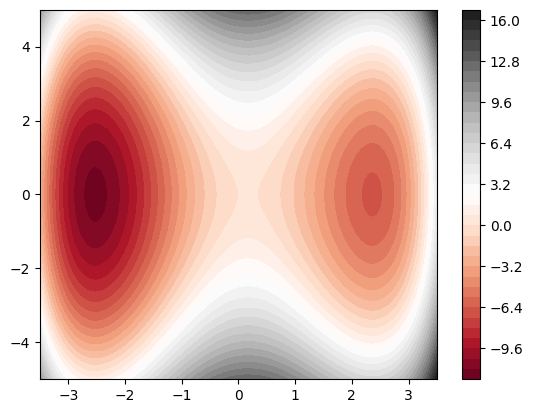

In [2]:
# Contour plot code snippet from https://jakevdp.github.io/PythonDataScienceHandbook/04.04-density-and-contour-plots.html
import matplotlib.pyplot as plt
import numpy as np

xmin, xmax = -3.5, 3.5
ymin, ymax = -5, 5
nx, ny = 100, 100

x = np.linspace(xmin, xmax, nx)
y = np.linspace(ymin, ymax, ny)

X, Y = np.meshgrid(x, y)
E = f(X, Y)

plt.contourf(X, Y, E, 40, cmap='RdGy') 
plt.colorbar();

Note Figure 2a seems slightly wrong as the $x_1$ coordinate of the left minima should be less than -2 using the parameters provided in the SI section. It's just a minor problem for us.

Per the description from the methods section, the "MD simulations" are emulated by Metropolis Monte Carlo with steps drawn from an isotropic Gaussian. This is easy to code. We will generate two trajectories in each basin.

In [3]:
N = 1_000
T = 1.0
sigma = 0.1
min_l = np.array([-2.5, 0])
saddle = np.array([0, 0])
min_r = np.array([2.3, 0])


def generate_traj(init, N, seed=1) -> np.ndarray:
    np.random.seed(seed)
    pts = [init]
    while N > 1:
        next_pt = pts[-1] + np.random.normal(0, sigma, size=(2))
        E_last = f(pts[-1][0], pts[-1][1])
        E_curr = f(next_pt[0], next_pt[1])
        if np.random.uniform() <= min(1, np.exp(-1/T*(E_curr-E_last))): # kb=1
            pts.append(next_pt)
            N-=1
    return np.column_stack(pts)

traj_l = generate_traj(min_l, N)
traj_m = generate_traj(saddle, N)
traj_r = generate_traj(min_r, N)

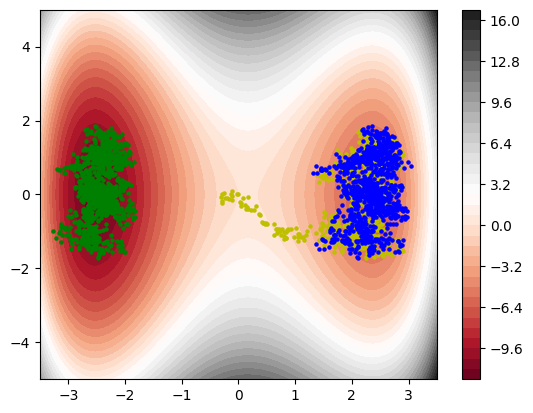

In [4]:
plt.contourf(X, Y, E, 40, cmap='RdGy') 
plt.colorbar();
plt.scatter(traj_l[0,:], traj_l[1,:], s=5, c='g')
plt.scatter(traj_m[0,:], traj_m[1,:], s=5, c='y')
plt.scatter(traj_r[0,:], traj_l[1,:], s=5, c='b')


We see that as expected, our sampling got stuck in each basin and if we start from the saddle point, it will slid into one of the basins (not necessarily the global minimum!) and got stuck there for a while. Now we have the artificial data we will use these to fit the BG model using both forward (sample-based) and reverse KL divergence (energy-based).

First we copy over the definitions.

In [5]:
import jax
import jax.numpy as jnp
import haiku as hk
from jax.config import config
config.update("jax_enable_x64", True) # is this necessary? Test later

class RealNVPLayer(hk.Module):
    def __init__(self, n_channels, n_hidden=100):
        super().__init__()
        self.S = hk.nets.MLP(output_sizes=[n_hidden, n_hidden, n_hidden, n_channels], activation=jax.nn.tanh)
        self.T = hk.nets.MLP(output_sizes=[n_hidden, n_hidden, n_hidden, n_channels], activation=jax.nn.relu)
    
    def forward(self, z1, z2):
        x1 = z1
        sz1 = self.S(z1)
        x2 = (z2 - self.T(x1)) * jnp.exp(-sz1)
        logdet = -jnp.sum(sz1)
        return x1, x2, logdet 
    
    def reverse(self, x1, x2):
        z1 = x1
        sx1 = self.S(x1)
        z2 = x2 * jnp.exp(sx1) + self.T(x1)
        logdet = jnp.sum(sx1)
        return z1, z2, logdet

class RealNVPBlock():
    def __init__(self, n_channels, n_hidden=100):
        super().__init__()
        self.layer1 = RealNVPLayer(n_channels, n_hidden)
        self.layer2 = RealNVPLayer(n_channels, n_hidden)
    
    def forward(self, z1, z2):
        y1, y2, ld1 = self.layer1.forward(z1, z2)
        x1, x2, ld2 = self.layer2.forward(y2, y1) # swap channels
        logdet = ld1 + ld2
        return x1, x2, logdet
    
    def reverse(self, x1, x2):
        y1, y2, ld1 = self.layer2.reverse(x1, x2)
        z1, z2, ld2 = self.layer1.reverse(y2, y1) # swap channels
        logdet = ld1 + ld2
        return z1, z2, logdet

class RealNVPStack():
    def __init__(self, n_channels, n_stacks, n_hidden=100):
        super().__init__()
        self.layers = [RealNVPBlock(n_channels, n_hidden) for _ in range(n_stacks)]
    
    def forward(self, z1, z2):
        logdet = 0
        for layer in self.layers:
            z1, z2, ld = layer.forward(z1, z2)
            logdet += ld
        return z1, z2, logdet
    
    def reverse(self, x1, x2):
        logdet = 0
        for layer in self.layers[::-1]:
            x1, x2, ld = layer.reverse(x1, x2)
            logdet += ld
        return x1, x2, logdet

In [6]:
# transpose so we can take batch of samples with the first dimension
traj_l = traj_l.T
traj_r = traj_r.T

In [7]:
rng_key = jax.random.PRNGKey(44)
batch_size, n_hidden, n_channels, n_layers = 100, 4, 1, 4
RealNVP_stack_forward = hk.without_apply_rng(hk.transform(lambda z1, z2: RealNVPStack(n_channels, n_layers, n_hidden).forward(z1, z2)))
RealNVP_stack_reverse = hk.without_apply_rng(hk.transform(lambda x1, x2: RealNVPStack(n_channels, n_layers, n_hidden).reverse(x1, x2)))
z1, z2 = jnp.ones([batch_size, n_channels]), jnp.ones([batch_size, n_channels])
params = RealNVP_stack_forward.init(rng_key, z1, z2)

In [8]:
import optax

# Again, these are Monte Carlo estimators and we train with SGD (what if we use entire dataset? 1,000 is doable)
def forward_KL(params, batch): # x.shape = n_batch, 2 * n_channels
    loss = 0
    x1, x2 = batch[:, :n_channels], batch[:, n_channels:]
    z1, z2, ldj = RealNVP_stack_reverse.apply(params, x1, x2)
    loss += -jnp.sum(optax.l2_loss(z1))
    loss += -jnp.sum(optax.l2_loss(z2))
    loss += jnp.sum(ldj)
    return -loss / batch_size

def reverse_KL(params, batch):
    loss = 0
    z1, z2 = batch[:, :n_channels], batch[:, n_channels:]
    x1, x2, ldj = RealNVP_stack_forward.apply(params, z1, z2)
    loss += jnp.sum(ldj)
    loss += 1/T * jnp.sum(f(x1, x2))
    return -loss / batch_size

def combined_KL(params, x_batch, z_batch):
    loss = 0.2*forward_KL(params, x_batch) + 0.8*reverse_KL(params, z_batch)

In [9]:
# hstack and then reshape interleaves rows of traj_l and traj_r
training_data = jnp.reshape(jnp.hstack((traj_l, traj_r)).reshape(2*N, 2), (20, batch_size, 2*n_channels))
training_data.shape

(20, 100, 2)

In [10]:
def fit(params, optimizer, epochs) -> optax.Params:
    opt_state = optimizer.init(params)
    
    @jax.jit
    def step(params, opt_state, batch):
        loss_value, grads = jax.value_and_grad(forward_KL)(params, batch)
        updates, opt_state = optimizer.update(grads, opt_state, params)
        params = optax.apply_updates(params, updates)
        return params, opt_state, loss_value

    for epoch in range(epochs):
        for i, batch in enumerate(training_data):
            params, opt_state, loss_value = step(params, opt_state, batch)
        print(f'Epoch {epoch}, loss: {loss_value}')
    return params

In [11]:
optimizer = optax.adam(learning_rate=1e-2)
params = fit(params, optimizer, 200)

Epoch 0, loss: 2.4669306278564656
Epoch 1, loss: 1.5307855696528143
Epoch 2, loss: 1.435792247009141
Epoch 3, loss: 1.3560999215088427
Epoch 4, loss: 1.4466511749070707
Epoch 5, loss: 1.3693613181247963
Epoch 6, loss: 1.4141619045488256
Epoch 7, loss: 1.2375292420310111
Epoch 8, loss: 1.2139309395477715
Epoch 9, loss: 1.5543672843189402
Epoch 10, loss: 1.3092502999548454
Epoch 11, loss: 1.2698547427168274
Epoch 12, loss: 1.2777335045404514
Epoch 13, loss: 1.0774861428878888
Epoch 14, loss: 0.8343917575853682
Epoch 15, loss: 1.2838811938801675
Epoch 16, loss: 1.4989348712552306
Epoch 17, loss: 1.3898316480241142
Epoch 18, loss: 1.2825964073087632
Epoch 19, loss: 1.363297337829258
Epoch 20, loss: 1.060636159619129
Epoch 21, loss: 1.3310413603412365
Epoch 22, loss: 1.6872988332389247
Epoch 23, loss: 1.2383907521950146
Epoch 24, loss: 0.979549436806391
Epoch 25, loss: 1.3876280827774423
Epoch 26, loss: 1.0603720063104967
Epoch 27, loss: 1.8394434766823176
Epoch 28, loss: 0.9390372662228079

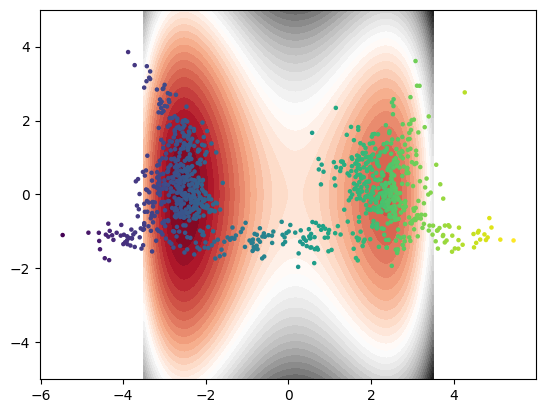

In [12]:
z_new = jax.random.normal(rng_key, shape=(1000, 2))
x_new1, x_new2, _ = RealNVP_stack_forward.apply(params, z_new[:,0:1], z_new[:,1:2])
plt.contourf(X, Y, E, 40, cmap='RdGy') 
plt.scatter(x_new1, x_new2, s=5, c=x_new1)
# plt.xlim([-5, 5])
# plt.ylim([-5, 5])

Note after the first 200 epochs of using forward KL divergence, i.e., making the modelled distribution similar to the reference distribution, we model the basins covered by the two trajectories well, but the interpolated path in the middle is not exactly the lowest energy path. We may simulate more, (which is mentioned in the SI section of the paper) using reverse KL divergence that evaluates energy of generated states to fix the problem.

In [13]:
batch_size, n_hidden, n_channels, n_layers = 1000, 4, 1, 4
random_data = jax.random.normal(rng_key, (2, batch_size, 2*n_channels))
training_data = jnp.reshape(training_data, (2, batch_size, 2*n_channels))


In [14]:
def more_fit(params, optimizer, epochs) -> optax.Params:
    opt_state = optimizer.init(params)
    
    @jax.jit
    def step(params, opt_state, batch):
        x_batch, z_batch = batch
        loss_value, grads = jax.value_and_grad(combined_KL)(params, x_batch, z_batch)
        updates, opt_state = optimizer.update(grads, opt_state, params)
        params = optax.apply_updates(params, updates)
        return params, opt_state, loss_value

    for epoch in range(epochs):
        for i, batch in enumerate(training_data, random_data):
            params, opt_state, loss_value = step(params, opt_state, batch)
        print(f'Epoch {epoch}, loss: {loss_value}')
    return params

In [15]:
optimizer = optax.adam(learning_rate=1e-3)
params = fit(params, optimizer, 500)

Epoch 0, loss: 0.7344465374637419
Epoch 1, loss: 0.7013652430935544
Epoch 2, loss: 0.6852747324395243
Epoch 3, loss: 0.6779225910805172
Epoch 4, loss: 0.670039807513549
Epoch 5, loss: 0.6593186926914605
Epoch 6, loss: 0.6484269079518292
Epoch 7, loss: 0.6402164033716619
Epoch 8, loss: 0.6352666542615952
Epoch 9, loss: 0.6315790650085478
Epoch 10, loss: 0.6266569155218392
Epoch 11, loss: 0.6196557173243886
Epoch 12, loss: 0.6115390740457674
Epoch 13, loss: 0.6038466044640939
Epoch 14, loss: 0.597393462905833
Epoch 15, loss: 0.5919036942313529
Epoch 16, loss: 0.5868197818150638
Epoch 17, loss: 0.582055042734771
Epoch 18, loss: 0.5778130652726532
Epoch 19, loss: 0.574020420647102
Epoch 20, loss: 0.5700234933848114
Epoch 21, loss: 0.565281991840901
Epoch 22, loss: 0.5599388031482501
Epoch 23, loss: 0.554528887060415
Epoch 24, loss: 0.5494220672765487
Epoch 25, loss: 0.5446493025404634
Epoch 26, loss: 0.5401150009858728
Epoch 27, loss: 0.5357878594656637
Epoch 28, loss: 0.5315831987804341
E

Epoch 279, loss: 0.3440427293206245
Epoch 280, loss: 0.3439260067672476
Epoch 281, loss: 0.34380135431609815
Epoch 282, loss: 0.34367552717124206
Epoch 283, loss: 0.3435558247386888
Epoch 284, loss: 0.3434295467064234
Epoch 285, loss: 0.3432922004349305
Epoch 286, loss: 0.3431439498812048
Epoch 287, loss: 0.3429930021236617
Epoch 288, loss: 0.342843626955613
Epoch 289, loss: 0.3426928299483376
Epoch 290, loss: 0.3425389486307
Epoch 291, loss: 0.342388045898947
Epoch 292, loss: 0.34224656796499153
Epoch 293, loss: 0.3421170403240592
Epoch 294, loss: 0.34199467910729753
Epoch 295, loss: 0.34187354211956755
Epoch 296, loss: 0.3417504244539147
Epoch 297, loss: 0.3416297292348063
Epoch 298, loss: 0.34150746700291096
Epoch 299, loss: 0.34138122780633673
Epoch 300, loss: 0.3412524830983838
Epoch 301, loss: 0.34112158831982153
Epoch 302, loss: 0.3409857577393647
Epoch 303, loss: 0.3408466173687051
Epoch 304, loss: 0.3407082169934122
Epoch 305, loss: 0.34057170922229685
Epoch 306, loss: 0.34043

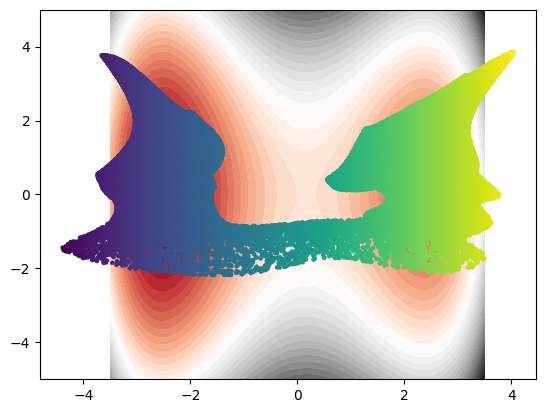

In [20]:
z_new = jax.random.uniform(rng_key, shape=(100000, 2), minval=-4, maxval=4)
x_new1, x_new2, _ = RealNVP_stack_forward.apply(params, z_new[:,0:1], z_new[:,1:2])
plt.contourf(X, Y, E, 40, cmap='RdGy') 
plt.scatter(x_new1, x_new2, s=5, c=x_new1)

Hmmm, so looks like this doesn't really fix the problem. 